# Additional Research Tools

I've been using Python actively for research since 2015. One of the beauties of Python is that it's very easy to write your own functions, modules, and packages for workflows you do often. Every time that I hit something which was pretty difficult in Python, I built a tool for it to make it easy. The result after these years of doing this is that I've built up a lot of tools that make empirical research in Python easier. Let's take a look through them.

## Table of Contents

- [**pyexlatex**: Generate LaTeX directly from Python with a simplified API](#pyexlatex)
- [**regtools**: High-level tools for running regressions](#regtools)
- [**pd-utils**: Additional utilities to work with Pandas](#pd-utils)
- [**datacode**: Data pipelines for humans](#datacode)
- [**bibtex_gen**: Citation management using Mendeley API and BibTeX](#bibtex_gen)
- [**objcache**: Easily store Python objects for later (cache results)](#objcache)
- [**pyfileconf**: Function and class configuration as Python files, helpful for managing multiple complex configuations](#pyfileconf)


### Some General Imports

Import some packages we'll need across the examples.

In [1]:
import pandas as pd
import numpy as np
from numpy import nan

## `pyexlatex`

Generate LaTeX directly from Python with a simplified API.

NOTE: You must have a LaTeX distribution installed on your machine for this package to work. Tested with MikTeX and TeXLive on Windows and Linux.

NOTE: It is highly recommended to run this example in Jupyer Lab so that PDFs will be outputted inline in Jupyter.

Find more at [the documentation](https://nickderobertis.github.io/py-ex-latex).

The most basic example:

In [2]:
import pyexlatex as pl

doc = pl.Document('woo')
doc

<Document>

As a LaTeX str:

In [3]:
print(doc)

\documentclass[]{article}
\usepackage{amsmath}
\usepackage{pdflscape}
\usepackage{booktabs}
\usepackage{array}
\usepackage{threeparttable}
\usepackage{fancyhdr}
\usepackage{lastpage}
\usepackage{textcomp}
\usepackage{dcolumn}
\newcolumntype{L}[1]{>{\raggedright\let\newline\\\arraybackslash\hspace{0pt}}m{#1}}
\newcolumntype{C}[1]{>{\centering\let\newline\\\arraybackslash\hspace{0pt}}m{#1}}
\newcolumntype{R}[1]{>{\raggedleft\let\newline\\\arraybackslash\hspace{0pt}}m{#1}}
\newcolumntype{.}{D{.}{.}{-1}}
\usepackage[T1]{fontenc}
\usepackage{caption}
\usepackage{subcaption}
\usepackage{graphicx}
\usepackage[margin=0.8in, bottom=1.2in]{geometry}
\usepackage[page]{appendix}
\pagestyle{fancy}
\renewcommand{\headrulewidth}{0pt}
\fancyhead{}
\rfoot{Page \thepage\  of \pageref{LastPage}}
\cfoot{}
\begin{document}
woo
\end{document}


Object-oriented API example:

In [4]:
my_value = 5

contents = [
    pl.Section(
        [
            f'Some text. My value is {my_value}.',
            pl.UnorderedList([
                'A bullet',
                'List'
            ])
        ],
        title='First Section'
    )
]

doc = pl.Document(contents)
doc

<Document>

Template-driven API example:

In [5]:
template = """
{% filter Section(title='First Section') %}

Some text. My value is {{ my_value }}.
{{ [
    'A bullet',
    'List'
] | UnorderedList }}

{% endfilter %}
"""

class MyModel(pl.Model):
    my_value = 5
    
content = [MyModel(template_str=template)]
doc = pl.Document(content)
doc

<Document>

A combination works as well.

In [6]:
content = [
    MyModel(template_str=template),
    pl.Section(
        [
            f'Some text. My value is {my_value}.',
            pl.UnorderedList([
                'A bullet',
                'List'
            ])
        ],
        title='Second Section'
    )
]

doc = pl.Document(content)
doc

<Document>

Equations are fine too.

In [7]:
content.append(
    pl.Section(
        [
            ['You can use inline equations', pl.Equation('y = mx + b'), 
             'by default, or pass inline=False to separate them', pl.Equation('E = MC^2', inline=False)]
        ],
        title='Equations Example'
    )
)
pl.Document(content)

<Document>

You can create tables from `DataFrames`.

In [8]:
# Create a DataFrame for example
df = pd.DataFrame(
    [
        (1, 2, 'Stuff'),
        (3, 4, 'Thing'),
        (5, 6, 'Other Thing'),
    ],
    columns=['a', 'b', 'c']
)

table = pl.Table.from_list_of_lists_of_dfs([[df]])
pl.Document([table])

<Document>

Publication-quality multi-panel tables with captions, below text, consolidation of indices, etc. are supported.

In [9]:
df.set_index('c', inplace=True)

In [10]:
table = pl.Table.from_list_of_lists_of_dfs(
    [
        [df, df],
        [df, df]
    ],
    shape=(1, 2),
    include_index=True,
    panel_names=['Top Panel', 'Bottom Panel'],
    caption='My First Complex Table',
    below_text="""
    Some description of my table. Isn't it nice to be able to do everything all in one command?
    """,
    label='tables:one'
)
content.append(table)
pl.Document(content)

<Document>

Figures are supported as well, with an integration for `matplotlib` and therefore `pandas` as well (can also be loaded from file).

<Document>

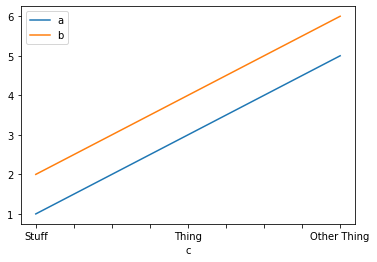

In [11]:
ax = df.plot()
fig = ax.get_figure()

pl_fig = pl.Figure.from_dict_of_names_and_plt_figures(
    {
        'My Subfigure': fig,  # more subfigures can be passed in the same way
    },
    '.',  # output location
    figure_name='My Figure',
    label='figs:one',
    position_str_name_dict={
        'My Subfigure': r'[t]{0.95\linewidth}'  # LaTeX positioning strings accepted (be sure to use r'' to escape \)
    }
)
content.append(pl_fig)
pl.Document(content)

Table/Figure references work just fine and you can use the objects directly if desired.

In [12]:
content.append(
    pl.Section(
        [
            ['See Table', pl.Ref(table.label), 'and Figure', pl.Ref(pl_fig.label)]
        ],
        title='Example for Table and Figure References'
    )
)
pl.Document(content)

<Document>

Support for citations as well. There is an easier way to create these using `bibtex_gen` [as shown in that section](#bibtex_gen).

In [13]:
bibtex_item = pl.BibTexArticle(
    'using-pyexlatex',
    'Nick DeRobertis',
    'How to Use pyexlatex',
    'The Journal of Awesome Stuff',
    '2020',
    volume='Vol 1',
    pages='1-2',
)

content.extend([
    pl.Section(
        [
            ['As shown by', pl.CiteT('using-pyexlatex'), pl.Monospace('pyexlatex'), 'is pretty awesome.']
        ],
        title='Example for Using Citations'
    ),
    pl.Bibliography([bibtex_item], style_name='jof')
])
pl.Document(content)

<Document>

Add metadata to the document such as author, title, etc.

In [14]:
footnotes = {
        'nick': pl.Footnote(
            "University of Florida, PhD Candidate, Tel: (352)392-4669, Email: Nicholas.DeRobertis@Warrington.ufl.edu"
        ),
        'other': pl.Footnote(
            "Example University, Professor"
        )
    }

abstract = """
A short abstract which is included for example purposes. There is a lot of configuration available for how the document
itself renders. Feel free to take this as an example of something that looks pretty good and then look through the 
documentation for how to modify it.
"""

doc = pl.Document(
    content,
    authors=[
        f'{pl.SmallCaps("Nick DeRobertis")}{footnotes["nick"]}',
        f'{pl.SmallCaps("Other Person")}{footnotes["other"]}',
    ], 
    title='The title of my paper', 
    abstract=abstract,
    page_modifier_str='margin=1.0in',
    section_numbering_styles=dict(
        section=r'\Roman{section}',
        subsection=r'\thesection.\Alph{subsection}',
        subsubsection=r'\thesubsection.\arabic{subsubsection}',
        subfigure=r'\roman{subfigure}',
    ),
    floats_at_end=True,
    font_size=12,
    line_spacing=2,
    tables_relative_font_size=-2,
    page_style='fancyplain',
    custom_headers=[
        pl.Header(pl.SmallCaps('My Short Title'), align='left'),
        pl.Header(pl.SmallCaps(['Page ', pl.ThisPageNumber()]))
    ],
    page_numbers=False,
    separate_abstract_page=True,
    extra_title_page_lines=[
        [pl.Italics('JEL Classification:'), 'E42, E44, E52, G12, G15, [add more here]'],
        [pl.Italics('Keywords:'), 'Thing; stuff; other stuf'],
    ],
)
doc

<Document>

LaTeX presentations with Beamer are supported as well.

In [15]:
pres_content = [
    pl.Frame(
        [
            'Some text',
            pl.Block(
                [
                    'more text'
                ],
                title='My Block'
            ),
            pl_fig
        ]
    )
]
pl.Presentation(pres_content)

<Item(name=document, contents=\begin{frame}
Some text
\begin{block}{My Block}
more text
\end{block}
\begin{figure}
\includegraphics[width=0.95\linewidth]{Sources/My_Subfigure.pdf}
\caption{My Figure}
\label{figs:one}
\end{figure}
\end{frame})>

And with sections, metadata, frame templates, etc.

In [16]:
pl_fig

<Figure(subfigures=[<Graphic(./My Subfigure.pdf, width=0.95\linewidth)>], caption=\caption{My Figure})>

In [17]:
pres_content = [
    pl.Section(
        [
            pl.DimRevealListFrame(
                [
                    'some',
                    'bullet',
                    'points'
                ],
                title='First Frame'
            ),
        ],
        title='First Section'
    ),
    pl.Section(
        [
            pl.Frame(
                pl_fig,
                title='Second Frame'
            ),
        ],
        title='Second Section'
    )
    
]
pl.Presentation(
    pres_content, 
    title='My Presentation',
    authors=['Nick DeRobertis', 'Some Person'],
    short_title='Pres',
    subtitle='An Example Presentation',
    short_author='ND',
    institutions=[
        ['University of Florida'],
        ['University of Florida', 'Some other Place']
    ],
    short_institution='UF',
    nav_header=True,
    toc_sections=True
)

<Item(name=document, contents=\title[Pres]{My Presentation}
\subtitle{An Example Presentation}
\author[ND]{Nick DeRobertis\inst{1}, Some Person\inst{2}}
\date{\today}
\begin{frame}
\titlepage
\label{title-frame}
\end{frame}
\begin{section}{First Section}
\begin{frame}
\frametitle{First Frame}
\begin{itemize}
\item<+-> \textcolor<.(1)->{black!30}{some}
\vfill
\item<+-> \textcolor<.(1)->{black!30}{bullet}
\vfill
\item<+-> points
\end{itemize}
\end{frame}
\end{section}
\begin{section}{Second Section}
\begin{frame}
\frametitle{Second Frame}
\begin{figure}
\includegraphics[width=0.95\linewidth]{Sources/My_Subfigure.pdf}
\caption{My Figure}
\label{figs:one}
\end{figure}
\end{frame}
\end{section})>

By default it produces the "slides" version that you would use while presenting. It can also produce a "handouts" version which removes all the effects (overlays).

In [18]:
pl.Presentation(
    pres_content, 
    title='My Presentation',
    authors=['Nick DeRobertis', 'Some Person'],
    short_title='Pres',
    subtitle='An Example Presentation',
    short_author='ND',
    institutions=[
        ['University of Florida'],
        ['University of Florida', 'Some other Place']
    ],
    short_institution='UF',
    nav_header=True,
    toc_sections=True,
    handouts=True  # add this to remove presentation effects, good for distributing the PDF
)

<Item(name=document, contents=\title[Pres]{My Presentation}
\subtitle{An Example Presentation}
\author[ND]{Nick DeRobertis\inst{1}, Some Person\inst{2}}
\date{\today}
\begin{frame}
\titlepage
\label{title-frame}
\end{frame}
\begin{section}{First Section}
\begin{frame}
\frametitle{First Frame}
\begin{itemize}
\item some
\vfill
\item bullet
\vfill
\item points
\end{itemize}
\end{frame}
\end{section}
\begin{section}{Second Section}
\begin{frame}
\frametitle{Second Frame}
\begin{figure}
\includegraphics[width=0.95\linewidth]{Sources/My_Subfigure.pdf}
\caption{My Figure}
\label{figs:one}
\end{figure}
\end{frame}
\end{section})>

### Some Clean Up

Not important, just cleaning up temporary files from the example.

In [19]:
import os

temp_files = [
    'My Subfigure.pdf',
]

for file in temp_files:
    os.remove(file)

## `regtools`

High-level tools for running regressions.

Find more at [the documentation](https://nickderobertis.github.io/regtools).

### Some Setup

Create a DataFrame with Y and X variables and a known relationship between them. Also fill some cells with missing values.

In [20]:
df = pd.DataFrame(
    np.random.random((100, 4)),
    columns=['X1', 'X2', 'X3', r'$\epsilon$']
)
df['Y'] = df['X1'] * 5 + df['X2'] * 10 + df['X3'] * 20 + df[r'$\epsilon$'] * 10
df['f1'] = np.random.choice(['a', 'b', 'c'], size=(100,))
df['f2'] = np.random.choice(['d', 'e', 'f'], size=(100,))
df['date'] = pd.to_datetime(np.random.choice(['1/1/2000', '1/2/2000', '1/3/2000'], size=(100,)))
df.iloc[1, 2] = nan
df.iloc[3, 4] = nan
df.head()

,X1,X2,X3,$\epsilon$,Y,f1,f2,date
0,0.525146,0.727624,0.439303,0.339901,22.087040,c,e,2000-01-03
1,0.929235,0.410790,NaN,0.886726,36.543292,a,d,2000-01-03
2,0.774291,0.084230,0.750345,0.661231,26.332966,c,f,2000-01-03
3,0.017613,0.377797,0.711765,0.057002,NaN,a,e,2000-01-03
4,0.476393,0.011671,0.927905,0.910062,30.157394,a,d,2000-01-02


All regression automatically drop values with missing rows. By default they run with heteroskedasticity-robust standard errors and a constant.

In [21]:
import regtools

result = regtools.reg(
    df,
    'Y',
    ['X1', 'X2', 'X3']
)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     222.5
Date:                Wed, 19 Feb 2020   Prob (F-statistic):           1.45e-42
Time:                        09:10:43   Log-Likelihood:                -248.57
No. Observations:                  98   AIC:                             505.1
Df Residuals:                      94   BIC:                             515.5
Df Model:                           3                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8174      0.916      4.168      0.000       2.022       5.613
X1             5.2876      1.066      4.960      0.000       3.198       7.377
X2             9.2746      1.092      8.494      0.000       7.135      11.415
X3            22.6453      1.041     21.750      0.000      20.605      24.686
==============================================================================
Omnibus:                       44.279   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.689
Skew:                           0.103   Prob(JB):                       0.0353
Kurtosis:                       1.737   Cond. No.                         5.94
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

Run multiple regressions in one go with iteration tools. All functions also support fixed effects and multiway clustering.

In [22]:
reg_list, summ = regtools.reg_for_each_xvar_set_and_produce_summary(
    df,
    'Y',
    [
        ['X1'],
        ['X1', 'X2'],
        ['X1', 'X3'],
        ['X1', 'X2', 'X3']
    ],
    fe=[['f1', 'f2']],
    entity_var='f1',
    time_var='date',
    cluster=['f1', 'f2'],
    robust=False
)
summ

/home/nick/.local/share/virtualenvs/py-research-workflows-LM8cXNcD/lib/python3.7/site-packages/linearmodels/panel/results.py:85: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/nick/.local/share/virtualenvs/py-research-workflows-LM8cXNcD/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/nick/.local/share/virtualenvs/py-research-workflows-LM8cXNcD/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/nick/.local/share/virtualenvs/py-research-workflows-LM8cXNcD/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
/home/nick/.local/share/virtualenvs/py-research-workflows-LM8cXNcD/lib/pyt

,Y I,Y II,Y III,Y IIII
R-squared,nan,nan,nan,nan
,,,,
X1,7.00***,8.01***,4.11***,4.99***
,(4.15),(6.33),(3.40),(7.38)
X2,,12.11***,,9.48***
,,(33.51),,(9.43)
X3,,,23.77***,22.68***
,,,(23.68),(28.68)
Intercept,18.68***,12.64,8.08***,3.85***
,(92.44),,(8.46),(7.78)


Default is OLS. Other supported types: Probit, Logit, Quantile, Fama-Macbeth. Just pass the string to `reg_type`.

In [23]:
reg_list, summ = regtools.reg_for_each_xvar_set_and_produce_summary(
    df,
    'Y',
    [
        ['X1'],
        ['X1', 'X2'],
        ['X1', 'X3'],
        ['X1', 'X2', 'X3']
    ],
    reg_type='quantile',
    q=0.9
)
summ

,Y I,Y II,Y III,Y IIII
X1,5.03,9.16*,6.06**,5.29***
,(1.02),(1.96),(2.02),(3.29)
X2,,11.99**,,10.30***
,,(2.50),,(5.90)
X3,,,24.42***,20.90***
,,,(8.52),(11.39)
Intercept,31.34***,23.11***,13.01***,8.13***
,(11.41),(6.19),(8.19),(6.42)
N,99,99,98,98
Adj-R2,nan,nan,nan,nan


In [24]:
reg_list, summ = regtools.reg_for_each_xvar_set_and_produce_summary(
    df,
    'Y',
    [
        ['X1'],
        ['X1', 'X2'],
        ['X1', 'X3'],
        ['X1', 'X2', 'X3']
    ],
    reg_type='fama-macbeth',
    entity_var='f1',
    time_var='date'
)
summ

/home/nick/.local/share/virtualenvs/py-research-workflows-LM8cXNcD/lib/python3.7/site-packages/linearmodels/panel/model.py:2631: InferenceUnavailableWarning: The number of time-series observation available to estimate cross-sectional
regressions, 3, is less than the number of parameters in the model. Parameter
inference is not available.
  InferenceUnavailableWarning,


,Y I,Y II,Y III,Y IIII
R-squared,nan,nan,nan,nan
,,,,
X1,6.82***,7.76***,4.26***,5.31***
,(3.56),(4.42),(4.67),(5.71)
X2,,10.63**,,8.86***
,,(2.61),,(35.73)
X3,,,22.62***,22.17***
,,,(7.89),(14.88)
Intercept,18.85***,13.45***,8.65***,4.25***
,(19.91),(4.85),(9.31),(9.02)


## `pd-utils`

Additional utilities to work with Pandas.

Find more at [the documentation](https://nickderobertis.github.io/pd-utils).

### Some Setup

In [25]:
df1 = pd.DataFrame(
    [
        ("001076", "3/1/1995"),
        ("001076", "4/1/1995"),
        ("001722", "1/1/2012"),
        ("001722", "7/1/2012"),
        ("001722", nan),
        (nan, "1/1/2012"),
    ],
    columns=["GVKEY", "Date"],
)
df1["Date"] = pd.to_datetime(df1["Date"])

df2 = pd.DataFrame(
    [
        ("001076", "2/1/1995"),
        ("001076", "3/2/1995"),
        ("001722", "11/1/2011"),
        ("001722", "10/1/2011"),
        ("001722", nan),
        (nan, "1/1/2012"),
    ],
    columns=["GVKEY", "Date"],
)
df2["Date"] = pd.to_datetime(df2["Date"])

df3 = pd.DataFrame(
    data=[
        (10516, "a", "1/1/2000", 1.01, 0),
        (10516, "a", "1/2/2000", 1.02, 1),
        (10516, "a", "1/3/2000", 1.03, 1),
        (10516, "a", "1/4/2000", 1.04, 0),
        (10516, "b", "1/1/2000", 1.05, 1),
        (10516, "b", "1/2/2000", 1.06, 1),
        (10516, "b", "1/3/2000", 1.07, 1),
        (10516, "b", "1/4/2000", 1.08, 1),
        (10517, "a", "1/1/2000", 1.09, 0),
        (10517, "a", "1/2/2000", 1.1, 0),
        (10517, "a", "1/3/2000", 1.11, 0),
        (10517, "a", "1/4/2000", 1.12, 1),
    ],
    columns=["PERMNO", "byvar", "Date", "RET", "weight"],
)

In [26]:
df1

,GVKEY,Date
0,001076,1995-03-01
1,001076,1995-04-01
2,001722,2012-01-01
3,001722,2012-07-01
4,001722,NaT
5,NaN,2012-01-01


In [27]:
df2

,GVKEY,Date
0,001076,1995-02-01
1,001076,1995-03-02
2,001722,2011-11-01
3,001722,2011-10-01
4,001722,NaT
5,NaN,2012-01-01


In [28]:
df3

,PERMNO,byvar,Date,RET,weight
0,10516,a,1/1/2000,1.01,0
1,10516,a,1/2/2000,1.02,1
2,10516,a,1/3/2000,1.03,1
3,10516,a,1/4/2000,1.04,0
4,10516,b,1/1/2000,1.05,1
5,10516,b,1/2/2000,1.06,1
6,10516,b,1/3/2000,1.07,1
7,10516,b,1/4/2000,1.08,1
8,10517,a,1/1/2000,1.09,0
9,10517,a,1/2/2000,1.10,0


### `tradedays`

Work directly with US market trading days.

In [29]:
import pd_utils

pd.date_range(
    start='1/1/2000',
    end='1/31/2000',
    freq=pd_utils.tradedays()
)

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14', '2000-01-18', '2000-01-19',
               '2000-01-20', '2000-01-21', '2000-01-24', '2000-01-25',
               '2000-01-26', '2000-01-27', '2000-01-28', '2000-01-31'],
              dtype='datetime64[ns]', freq='C')

### `left_merge_latest`

Merge the latest data available in the right `DataFrame` to the left `DataFrame`.

In [30]:
pd_utils.left_merge_latest(
    df1,
    df2,
    on='GVKEY',
    max_offset=pd.Timedelta(days=30),
#     max_offset=pd_utils.tradedays() * 20
)

,GVKEY,Date,Date_y
0,001076,1995-03-01,1995-02-01
1,001076,1995-04-01,1995-03-02
2,001722,2012-01-01,NaT
3,001722,2012-07-01,NaT
4,001722,NaT,NaT
5,NaN,2012-01-01,NaT


### `averages`

Equal and value-weighted averages, optionally by groups

In [31]:
pd_utils.averages(
    df3,
    'RET',
    ['PERMNO', 'byvar'],
    wtvar='weight',
)

,PERMNO,byvar,RET,RET_wavg
0,10516,a,1.025,1.025
1,10516,b,1.065,1.065
2,10517,a,1.105,1.120


### `portfolio`

Form porfolios from some numeric column.

In [32]:
pd_utils.portfolio(
    df3,
    'RET',
    ngroups=3,
#     cutoffs=[1.02, 1.07],
#     quant_cutoffs=[0.2],
    byvars='Date',
)

,PERMNO,byvar,Date,RET,weight,portfolio
0,10516,a,1/1/2000,1.01,0,1
1,10516,a,1/2/2000,1.02,1,1
2,10516,a,1/3/2000,1.03,1,1
3,10516,a,1/4/2000,1.04,0,1
4,10516,b,1/1/2000,1.05,1,2
5,10516,b,1/2/2000,1.06,1,2
6,10516,b,1/3/2000,1.07,1,2
7,10516,b,1/4/2000,1.08,1,2
8,10517,a,1/1/2000,1.09,0,3
9,10517,a,1/2/2000,1.10,0,3


### `long_to_wide`

Pandas has a built in `wide_to_long` function but not `long_to_wide`. There is `.pivot` but it can't handle multiple by variables.

In [33]:
pd_utils.long_to_wide(
    df3,
    ["PERMNO", "byvar"], 
    "RET", 
    colindex="Date",
    colindex_only=True
)

,PERMNO,byvar,weight,1/1/2000,1/2/2000,1/3/2000,1/4/2000
0,10516,a,0,1.01,1.02,1.03,1.04
1,10516,a,1,1.01,1.02,1.03,1.04
2,10516,b,1,1.05,1.06,1.07,1.08
3,10517,a,0,1.09,1.10,1.11,1.12
4,10517,a,1,1.09,1.10,1.11,1.12


### `winsorize`

Winsorize data, optionally by groups, optionally a subset of columns, and optionally only to top or bottom.

In [34]:
pd_utils.winsorize(
    df3, 
    0.4, 
    subset="RET", 
    byvars=["PERMNO", "byvar"],
)

,PERMNO,byvar,Date,RET,weight
0,10516,a,1/1/2000,1.022624,0
1,10516,a,1/2/2000,1.022624,1
2,10516,a,1/3/2000,1.026720,1
3,10516,a,1/4/2000,1.026720,0
4,10516,b,1/1/2000,1.062624,1
5,10516,b,1/2/2000,1.062624,1
6,10516,b,1/3/2000,1.066720,1
7,10516,b,1/4/2000,1.066720,1
8,10517,a,1/1/2000,1.102624,0
9,10517,a,1/2/2000,1.102624,0


### `formatted_corr_df`

Nicely formatted correlations.

In [35]:
pd_utils.formatted_corr_df(df3)

,PERMNO,RET,weight
PERMNO,1.00,,
RET,0.82,1.00,
weight,-0.48,-0.12,1.00


## `datacode`

Data pipelines for humans.

NOTE: Under active development. API is experimental and subject to change.

Find more at [the documentation](https://nickderobertis.github.io/data-code).

Features:

- Deal with the concept of variables rather than columns in a DataFrame
- Apply transformations to variables to update both the values and name of the variable, but still be able to say it's the same variable
    - E.g. take lag of variable "A", now it is shown as A$_{t - 1}$ but you can still work with it as the same variable without parsing the name
- Access variables by `short_keys` and tab-completion but have them displayed with the label in the `DataFrame`. 
- Associate symbols and descriptions with variables. Generates symbols by default and you can override.
- Attach data pipelines to generated data sources. It checks when the original sources were last modified, and if they were more recently modified than the pipeline was run, will run the pipeline again automatically.
- Easier merges with data merge pipelines and smart merge options
- Everything is extendible so you can add your own custom logic
- Describe your data sources in detail to enable some features:
    - Built-in transformations are index-aware. E.g. you have described that rows are indexed by firm and time. When you take a lag of the variable, it will automatically realize it should take the lag across the time dimension and within the firm
    - (Planned feature): Tell it what variables you want, and it will figure out the merges to make it happen

In [36]:
# TODO: add examples for datacode

## `bibtex_gen`

Citation management using Mendeley API and BibTeX.

Find more at [the documentation](https://nickderobertis.github.io/bibtex-gen).

## `objcache`

Easily store Python objects for later (cache results).

Find more at [the documentation](https://nickderobertis.github.io/obj-cache).

I use this in my workflow so that I can run analysis and store tables and figures with little effort, then later when I generate the paper I retrieve the tables and figures from the cache. That way I can update everything by running the analysis then generating the paper, or I can update just the text in the paper and generate it quickly using the pre-existing tables and figures.

In [37]:
from objcache import ObjectCache

cache = ObjectCache('cache.zodb', ('a', 'b'))
cache.store(5)

# Later session
cache = ObjectCache('cache.zodb', ('a', 'b'))
result = cache.get()
print(result)

5


### Some Cleanup

Not important, just to clean up files generated from the example.

In [38]:
import os

temp_files = [
    'cache.zodb',
    'cache.zodb.index',
    'cache.zodb.lock',
    'cache.zodb.tmp'
]

for file in temp_files:
    os.remove(file)

## `pyfileconf`

Function and class configuration as Python files, helpful for managing multiple complex configuations.

NOTE: Under active development. API is experimental and subject to change.

Find more at [the documentation](https://nickderobertis.github.io/py-file-conf).

Features:

- Easy way to have multiple configurations for a single function or class
- Generates Python file templates for configuration, complete with all the arguments, type annotations, and default values of function or class
- Run/get configured functions/classes from Python or the command line
- Update configurations at run-time in a Python script
    - Easy to do config-based scripting. E.g.: Run the whole analysis with 3, 4, and 5 portfolios.
- Works very well with `datacode` where you need to have many variables, sources, etc. configured

In [39]:
# TODO: add examples for pyfileconf